In [1]:
# using Pkg
# Pkg.generate("model2")

In [2]:
# using Pkg
# Pkg.add("OrdinaryDiffEq")
# Pkg.add("DifferentialEquations")
# Pkg.add("ModelingToolkit")
# Pkg.add("DataDrivenDiffEq")
# Pkg.add("LinearAlgebra")
# Pkg.add("DiffEqSensitivity")
# Pkg.add("Optim")
# Pkg.add("DiffEqFlux")
# Pkg.add("Flux")
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("GLM")
# Pkg.add("StatsModels")
# Pkg.add("CSV")
# Pkg.add("Interpolations")
# Pkg.add("JLD2")
# Pkg.add("Suppressor")
# Pkg.add("Distributed")
# Pkg.add("ParallelDataTransfer")
# Pkg.add("LaTeXStrings")
# Pkg.add("Statistics")
# Pkg.add("StatsBase")

In [3]:
println(@__DIR__)
using Pkg
# Pkg.update()
Pkg.activate(string(@__DIR__, "/model0/Project.toml"))
Pkg.status()
# Pkg.instantiate()

/home/ziyu/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload


 Activating environment at `~/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload/model0/Project.toml`


Project model0 v0.1.0
Status `~/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload/model0/Project.toml`
  [336ed68f] CSV v0.8.4
  [2445eb08] DataDrivenDiffEq v0.5.5
  [a93c6f00] DataFrames v0.22.5
  [aae7a2af] DiffEqFlux v1.23.0
  [41bf760c] DiffEqSensitivity v6.33.0
  [0c46a032] DifferentialEquations v6.16.0
  [587475ba] Flux v0.11.1
  [38e38edf] GLM v1.4.0
  [a98d9a8b] Interpolations v0.13.1
  [033835bb] JLD2 v0.4.2
  [b964fa9f] LaTeXStrings v1.2.1
  [961ee093] ModelingToolkit v5.11.0
  [429524aa] Optim v1.2.4
  [1dea7af3] OrdinaryDiffEq v5.51.1
  [2dcacdae] ParallelDataTransfer v0.5.0
  [91a5bcdd] Plots v1.6.12
  [2913bbd2] StatsBase v0.33.3
  [3eaba693] StatsModels v0.6.21
  [fd094767] Suppressor v0.2.0
  [9ff05d80] TickTock v1.1.0
  [8ba89e20] Distributed 
  [37e2e46d] LinearAlgebra 
  [10745b16] Statistics 


In [4]:
# # cd(@__DIR__)
# # using Pkg; Pkg.activate("."); Pkg.instantiate()
using OrdinaryDiffEq, DifferentialEquations
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
using DataFrames, GLM, StatsModels
using CSV
using Interpolations
using JLD2
using Suppressor
using Distributed
using ParallelDataTransfer
using LaTeXStrings, Statistics
using StatsBase
gr()

Plots.GRBackend()

# Cleaning the data and importing parameters

We import the weights and biases of the neural network for Botswana but these just represent a good initialisation point, whcih reduces time for training later on. 

In [5]:
file_dir2 = string(@__DIR__, "/model2_initialisation/")
country = "United_States"
paras = CSV.read(string(file_dir2,country,"_model2paras.csv"),normalizenames = true, DataFrame)

nnp = Array(paras[!, country])

412-element Array{Float64,1}:
 -0.43330707972830956
 -0.5536807215222634
 -0.011964421119994944
  0.3373153263003733
  0.1761922849372597
  0.5357269691874851
  0.38253408961140234
 -0.5167379967366356
  0.4118612892912689
  0.42848232433538797
  0.4265892064313845
  0.17365177544356927
 -0.4158392046596779
  ⋮
  0.1488127905862796
 -0.33583844884969954
 -0.1763979075246789
  0.2837432950684493
 -0.24791902349514247
  0.1330974774616129
  0.2934677459357888
  0.3775483323366863
  0.023107044985717848
  0.04507759469670959
  0.0054756560193240465
  0.005077634934906597

In [6]:
function getCleandataFrame(country)
    df_year=df[!,"Year"][2:end]
    df1=df[!,string(country,"_yt")]  #GDP
    df2=df[!,string(country,"_kt")] #capital per capita
    df3=df[!,string(country,"_srate")][2:end] # savig rate
    df6= df[!,string(country,"_et")] #population
    df4= df[!,string(country,"_nt")][2:end] #population
    df8=df6[1:end-1] .-df6[2:end]#de
    df6=df6[2:end]
    df5=df2[1:end-1] .-df2[2:end] #dk
    df2=df2[2:end]
    df7= df1[1:end-1] .-df1[2:end] # dydt
    df1=df1[2:end]
    newdf= DataFrame(Year=df_year,yt=df1, k=df2, srate=df3,nt=df4,dkdt=df5,dydt=df7,dedt=df8,et=df6)
    newdf=newdf[completecases(newdf), :]
    return newdf, df8, df5, df7
end

getCleandataFrame (generic function with 1 method)

In [7]:
df = CSV.read(string(@__DIR__, "/compileddf.csv"),
    normalizenames = true, 
    DataFrame)

,Year,Albania_et,Albania_yt,Albania_Popt,Albania_nt,Albania_Ktotal,Albania_kt
,Int64,Float64?,Float64?,Float64,Float64?,Float64?,Float64?
1,1959,missing,missing,1.57133e6,missing,missing,missing
2,1960,1.25819,0.001451,1.62311e6,0.0329562,missing,missing
3,1961,1.37419,0.001463,1.67664e6,0.0329743,missing,missing
4,1962,1.43996,0.001511,1.72814e6,0.0307175,missing,missing
5,1963,1.18168,0.001563,1.77972e6,0.029846,missing,missing
6,1964,1.11174,0.001616,1.83228e6,0.0295379,missing,missing
7,1965,1.1661,0.001675,1.88365e6,0.028035,missing,missing
8,1966,1.33306,0.001738,1.93296e6,0.0261784,missing,missing
9,1967,1.36375,0.001804,1.98406e6,0.0264345,missing,missing


In [8]:
newdf, df8, df5, df7=getCleandataFrame(country)
years_available=size(newdf)[1]


st = interpolate(newdf[!,"srate"], BSpline(Quadratic(Free(OnCell()))))
nt = interpolate(newdf[!,"nt"], BSpline(Quadratic(Free(OnCell()))))

kdata= newdf[!,"k"]
ydata=newdf[!,"yt"]
edata=newdf[!,"et"]
kic= newdf[!,"k"][1]
yic=newdf[!,"yt"][1]
eic=newdf[!,"et"][1]

newdf

,Year,yt,k,srate,nt,dkdt,dydt,dedt
,Int64,Float64?,Float64,Float64?,Float64?,Float64,Float64?,Float64?
1,1970,0.01503,0.0632449,0.215383,0.0117182,-0.0013165,0.000149,-1.25331
2,1971,0.015304,0.0651057,0.215138,0.0127236,-0.00186078,-0.000274,0.131049
3,1972,0.015944,0.067476,0.220847,0.0107627,-0.00237027,-0.00064,-0.768438
4,1973,0.016689,0.0706719,0.236784,0.00959046,-0.00319589,-0.000745,-0.76194
5,1974,0.016491,0.0743356,0.225658,0.00917847,-0.0036637,0.000198,1.00765
6,1975,0.016284,0.0764952,0.209196,0.00990863,-0.00215967,0.000207,1.10071
7,1976,0.016975,0.0777832,0.215083,0.00954749,-0.00128791,-0.000691,-0.755391
8,1977,0.017567,0.0809296,0.221992,0.0101085,-0.00314647,-0.000592,-0.374869
9,1978,0.018373,0.0851758,0.234459,0.0106521,-0.00424616,-0.000806,-0.440521


# Initialising the neural network

In [9]:
ann = FastChain(FastDense(3, 12, tanh),FastDense(12, 12, tanh),FastDense(12, 12, tanh),
                FastDense(12, 4))

(::FastChain{Tuple{FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#130"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#130"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#130"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(identity),DiffEqFlux.var"#initial_params#130"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}}}}) (generic function with 1 method)

# Optimising the neural network

In [10]:
function solownneqn1(du,u,p,t)
    sₜ = st(t) #savings rate
    nₜ = nt(t)

    k = u[1]
    y=u[2]
    e=u[3]
    α,δ,gᵦ,gₐ= ann([k,y,e],p)
    du[1] = sₜ*y-(δ+nₜ+gᵦ)*k # rate of change of kt
    du[2] = y*(gᵦ+α*du[1]/k) # rate of change of yt
    du[3] = e*(-gₐ+du[2]/y)
    return du
end

nntspan = (1.0e0,years_available*1.0) ## the year is hard coded, to be changed later
nndatasize = years_available
nntsteps = range(nntspan[1], nntspan[2], length=nndatasize)
u0 = Float32[kic,yic,eic] ## kt initial
prob_solownneqn = ODEProblem(solownneqn1, u0, nntspan, nnp)
pred = solve(prob_solownneqn, TRBDF2(),p=nnp, abstol=1e-4, reltol=1e-4, saveat = nntsteps)

function predicts(θ)
    Array(solve(prob_solownneqn,TRBDF2(),p=θ, abstol=1e-4, reltol=1e-4, saveat = nntsteps))
end

losses=[]

    
function loss(θ)
    pred = predicts(θ)
    kloss=sum(abs,(pred[1,:].-kdata))./ sum(pred[1,:].+ kdata)
    yloss=sum(abs, (pred[2,:].-ydata))./sum(pred[2,:].+ydata)
    eloss=sum(abs,(pred[3,:].-edata))./sum(pred[3,:].+edata)
    return ((kloss+eloss+yloss)), pred
end
          
        
# show(loss(nnp))
callback(θ,l,pred) = begin
        push!(losses, l)
#         display(plot(losses, yaxis=:log))
#         if length(losses)%99==0 #print every 50 steps
#             println(losses[end])

#         end
        false
end


callback (generic function with 1 method)

In [11]:
res1= DiffEqFlux.sciml_train(loss, nnp, ADAM(0.0001),cb=callback, maxiters=100)

while ((mean(losses[end-100:end-50])>=(1.001*mean(losses[end-49:end]))) || std(losses[end-49:end]) >=0.001) && length(losses) <3000

res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.0001),cb=callback, maxiters=200)
try
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.000001/100),cb=callback, maxiters=100)

catch e
    print("Problematics")
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.0001),cb=callback, maxiters=100)
end
res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.00001),cb=callback, maxiters=100)
try
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.000001/100),cb=callback, maxiters=100)
catch e
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.00001),cb=callback, maxiters=100)
    print("Problematics")
end

end
pred = solve(prob_solownneqn, TRBDF2(),p=res1.minimizer, abstol=1e-4, reltol=1e-4, saveat = nntsteps)

# kmse = Flux.mse(pred[1,:],kdata)
# ymse = Flux.mse(pred[2,:],ydata)
# emse = Flux.mse(pred[3,:],edata)
# println(kmse,"",ymse,"",emse)

loss: 0.0467: 100%|█████████████████████████████████████| Time: 0:00:18
loss: 0.0464: 100%|█████████████████████████████████████| Time: 0:00:35
loss: 0.0464: 100%|█████████████████████████████████████| Time: 0:00:17
loss: 0.0483: 100%|█████████████████████████████████████| Time: 0:00:34
loss: 0.0463: 100%|█████████████████████████████████████| Time: 0:00:17


retcode: Success
Interpolation: 1st order linear
t: 39-element Array{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
 11.0
 12.0
 13.0
  ⋮
 28.0
 29.0
 30.0
 31.0
 32.0
 33.0
 34.0
 35.0
 36.0
 37.0
 38.0
 39.0
u: 39-element Array{Array{Float32,1},1}:
 [0.06324493, 0.01503, 21.111252]
 [0.06495652, 0.015315738, 21.025682]
 [0.06676173, 0.015599924, 20.930462]
 [0.06886339, 0.015851967, 20.785397]
 [0.07102914, 0.016109768, 20.641497]
 [0.0729381, 0.016421853, 20.560123]
 [0.07480491, 0.016754208, 20.496265]
 [0.07678619, 0.0170832, 20.420084]
 [0.07891593, 0.01740461, 20.327166]
 [0.0811482, 0.017725904, 20.22653]
 [0.08321513, 0.018086622, 20.16303]
 [0.08539364, 0.018445825, 20.09007]
 [0.0876441, 0.018809704, 20.013756]
 ⋮
 [0.12073949, 0.026203569, 19.709602]
 [0.124046244, 0.02666939, 19.606846]
 [0.12744118, 0.027142705, 19.50323]
 [0.13080738, 0.027640225, 19.410355]
 [0.13413736, 0.028162679, 19.328045]
 [0.1374251, 0.028710771, 19.25644]
 [0.14066453, 0

In [12]:
# if training from randomly initialised neural network
theta=[]
et_init = interpolate(edata, BSpline(Quadratic(Free(OnCell()))));
kt_init = interpolate(kdata, BSpline(Quadratic(Free(OnCell()))));
yt_init = interpolate(ydata, BSpline(Quadratic(Free(OnCell()))));
kk = map(kt_init,1:years_available);
yy = map(yt_init,1:years_available);
ee = map(et_init,1:years_available);
dk_init = kk[1:end-1] .-  kk[2:end]
dydt_init = yy[1:end-1] .-  yy[2:end]
dedt_init = ee[1:end-1] .-  ee[2:end]

function eqn_1(α,θ)
    income = (1-θ).* kdata.^ (α)
   return income
end

function exp_2_eqn2_mse(δ,gᵦ)
    len= length(theta)
    θ = theta[len]
    dkdt = newdf[!,"srate"] .* (1-θ) .* newdf[!,"yt"] .- (δ .+ newdf[!,"nt"] .+ gᵦ) .* newdf[!,"k"] # rate of change of kt
    return dkdt
end

function exp2_eqn1_loss_mse(x)
    α = x[1]
    θ = x[2]
    pred= eqn_1(α,θ)
    return Flux.mse(newdf[!,"yt"], pred)
end

function exp2_eqn2_loss_mse(y)
    δ = y[1]
    gᵦ = y[2]
    pred= exp_2_eqn2_mse(δ,gᵦ)
    return Flux.mse(dk_init, pred[2:end])
end

optimizer1 = optimize(exp2_eqn1_loss_mse, [0.0,0.0])
α,θ = Optim.minimizer(optimizer1)
push!(theta, θ)
optmizer2=optimize(exp2_eqn2_loss_mse, [0.0,0.0])
δ, gᵦ=Optim.minimizer(optmizer2)

function soloweqn3alt(gₐ)
    de = edata[2:end] .* (-gₐ .+ dydt_init ./ ydata[2:end])
        end
        function losseqn3(xx)
            gₐ = xx
            pred= soloweqn3alt(gₐ)
            return Flux.mse(dedt_init, pred)
        end

reseqn3 = optimize(losseqn3, -200.0, 200.0)
gₐ = Optim.minimizer(reseqn3)

p123 = Float64[θ,δ,gᵦ,α,gₐ]

nnp = initial_params(ann)
nnp[409] = α
nnp[410] = δ
nnp[411] = gᵦ
nnp[412] = gₐ
nnp = nnp./10 #these modifications ease the training and reduce stiffness.

i=0
res_init= DiffEqFlux.sciml_train(loss, nnp, ADAM(),cb=callback, maxiters=200)

while ((mean(losses[end-100:end-50])>=(1.001*mean(losses[end-49:end]))) || std(losses[end-49:end]) >=0.001) && length(losses) <5000
    println("loop ", i)  
    
    res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, ADAM(0.001),cb=callback, maxiters=200)
    try
        res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, BFGS(0.00001),cb=callback, maxiters=1000)

    catch e
        print("Unable to train")
        res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, ADAM(0.01),cb=callback, maxiters=100)
    end
    res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, ADAM(0.0001),cb=callback, maxiters=200)
    try
        res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, BFGS(0.000001),cb=callback, maxiters=1000)

    catch e
        print("Unable to train")
        res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, ADAM(0.001),cb=callback, maxiters=100)
    end
    res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, ADAM(0.0001),cb=callback, maxiters=100)
    try
        res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, BFGS(initial_stepnorm=0.000001/10),cb=callback, maxiters=100)
    catch e
        res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, ADAM(0.0001),cb=callback, maxiters=100)
        print("Unable to train")
    end
    res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, ADAM(0.001),cb=callback, maxiters=200)
    try
        res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, BFGS(0.000001/100),cb=callback, maxiters=1000)

    catch e
        print("Unable to train")
        res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, ADAM(0.001),cb=callback, maxiters=100)
    end
    i+=1

end


while mean(losses[end-100:end])>0.1

res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, ADAM(0.0001),cb=callback, maxiters=200)
try
    res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, BFGS(initial_stepnorm=0.000001/100),cb=callback, maxiters=100)

catch e
    print("Unable to train")
    res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, ADAM(0.0001),cb=callback, maxiters=100)
end
res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, ADAM(0.00001),cb=callback, maxiters=100)
try
    res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, BFGS(initial_stepnorm=0.000001/100),cb=callback, maxiters=100)
catch e
    res_init= DiffEqFlux.sciml_train(loss, res_init.minimizer, ADAM(0.00001),cb=callback, maxiters=100)
    print("Unable to train")
end

end
pred_new = solve(prob_solownneqn, TRBDF2(),p=res_init.minimizer, abstol=1e-4, reltol=1e-4, saveat = nntsteps)

loss: 0.0445: 100%|█████████████████████████████████████| Time: 0:00:28


retcode: Success
Interpolation: 1st order linear
t: 39-element Array{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
 11.0
 12.0
 13.0
  ⋮
 28.0
 29.0
 30.0
 31.0
 32.0
 33.0
 34.0
 35.0
 36.0
 37.0
 38.0
 39.0
u: 39-element Array{Array{Float32,1},1}:
 [0.06324493, 0.01503, 21.111252]
 [0.06500933, 0.01534346, 21.061398]
 [0.066880144, 0.015664633, 21.013422]
 [0.069067344, 0.015998188, 20.973078]
 [0.07140081, 0.016340403, 20.935078]
 [0.07356761, 0.016684653, 20.890743]
 [0.07567132, 0.017033346, 20.84323]
 [0.07784174, 0.01738933, 20.796007]
 [0.08016102, 0.017754465, 20.751078]
 [0.08255748, 0.018127372, 20.706553]
 [0.084846474, 0.018504318, 20.658123]
 [0.08720039, 0.018889017, 20.609896]
 [0.08958506, 0.019280931, 20.561174]
 ⋮
 [0.12088388, 0.025957026, 19.66114]
 [0.12361707, 0.026481062, 19.607872]
 [0.12647372, 0.027016755, 19.555805]
 [0.12934291, 0.02756206, 19.503239]
 [0.13217708, 0.028116131, 19.449535]
 [0.13485084, 0.028676726, 19.393147]
 [0.1

## Printing the optimized parameters

In [13]:
for i in 1:39
    println(ann([kdata[i], ydata[i], edata[i]], res1.minimizer))
end

[-0.6765845171536354, -0.025291423476104108, 0.036882481027078015, 0.022875814719736084]
[-0.6763341738385604, -0.02495796662892838, 0.03695674323852971, 0.022944851840323174]
[-0.676795584332547, -0.029398207311995883, 0.03590689634795788, 0.022273951232693892]
[-0.6770155147199993, -0.0337737044713515, 0.03484412343199361, 0.02168373125216809]
[-0.6761449538053287, -0.02941302852787067, 0.035903468860988025, 0.022304037149446468]
[-0.6749439228021523, -0.024039359475561434, 0.03714178087619528, 0.023217716653447087]
[-0.675620991179721, -0.028295495279375193, 0.0361619101779628, 0.022500252495325487]
[-0.6757077754928464, -0.030809960968433803, 0.03556726874603258, 0.022127530731083297]
[-0.6757130971071342, -0.0338020733085459, 0.03485059614250349, 0.021707230591112917]
[-0.6753042419423358, -0.033605403283858276, 0.03489857979502786, 0.021749641984792997]
[-0.6742718180992794, -0.029108335945666447, 0.03594834758276401, 0.02248364220736944]
[-0.6728615331449777, -0.0241834243428411

# Plotting a graph

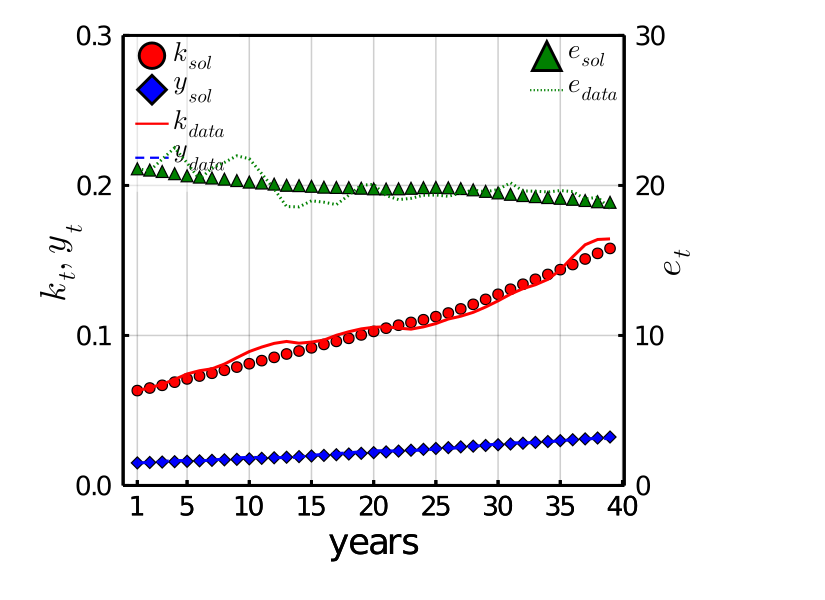

In [14]:
 function plot_graph(nnpred,country,nntstepsfull,kdata,ydata,edata)
    upscale = 0.5 #1 #8x upscaling in resolution
    fntsm = Plots.font("sans-serif", pointsize=round(12.0*upscale))
    fntlg = Plots.font("sans-serif", pointsize=round(16.0*upscale))
    default(titlefont=fntlg, guidefont=fntlg, tickfont=fntsm, legendfont=fntsm)
    default(size=(550*upscale,400*upscale)) #Plot canvas size
    default(dpi=300)
    
#     fctime = collect(Int(floor(size(nntstepsfull,1)*0.8))+1:1:size(nntstepsfull,1)) 
# #             println(fctime)
#             println(nntstepsfull)
    plotkyenn12ic= Plots.scatter(xaxis=nntstepsfull,nnpred[1:2,:]',
        label=[L"k_{sol}" L"y_{sol}"],color=[:red :blue],legend=(0.102,0.955),
        markershape=[:circle :diamond],markersize=4*upscale,
        ylabel=L"k_t,y_t",right_margin = 15Plots.mm)
            
    plot!(plotkyenn12ic,[kdata,ydata],label=[L"k_{data}" L"y_{data}"],linestyle=[:solid :dash],
        color=[:red :blue],ylim=(0,1.5.*round(maximum(kdata);sigdigits=1)),foreground_color_legend = nothing)

#     scatter!(plotkyenn12ic,nntstepsfull,nnpred[1:2,:]',
#         color=[:red :blue],markershape=[:circle :diamond], markersize=4,label=nothing)

    pr = twinx()
    
#     scatter!(pr,nntstepsfull,nnpred[3,:],
#         color=:green,legend=(0.89,0.954), markershape = [:utriangle], markersize=4, label=nothing)

    Plots.scatter!(pr,nntstepsfull,nnpred[3,:],
        label=L"e_{sol}",color=:green,legend=(0.89,0.954), markershape = [:utriangle], markersize=4*upscale,
        ylabel=L"e_t",right_margin = 15Plots.mm,
        foreground_color_legend = nothing,background_color_legend = nothing)
            
    plot!(pr,edata,label=L"e_{data}",color=:green,ylim=(0,1.5.*round(maximum(edata);sigdigits=1)),
                linestyle=:dot)
    
 xpts = collect(0:5:5*ceil(length(nntstepsfull)/5))
#     if xpts[end] != length(nntsteps)
#         push!(xpts,length(nntsteps))
        xpts[1]=1
#     end
    
   plot(plotkyenn12ic,xlabel = "years",xticks=xpts,box=:on,linewidth=2*upscale)
#     display(StatsPlots.plot(pl,xlabel = "Days post 21 March 2020",xticks=0:10:110,tickfont=12,
#         guidefont = 16,legendfontsize=12,legend=(0.1,0.92),
#         dpi=300,box=:on,linewidth=2*upscale))

#     savefig(string(country,"model5_190621"))
end

plot_graph(pred,country,nntsteps,kdata,ydata,edata)

# Calculating errors

In [15]:
kdata= newdf[!,"k"]
ydata=newdf[!,"yt"]
edata=newdf[!,"et"]

USA_k_pred = convert(Array{Float64},pred[1,:])
USA_y_pred = convert(Array{Float64},pred[2,:])
USA_e_pred = convert(Array{Float64},pred[3,:])

kdata = identity.(kdata)
ydata = identity.(ydata)
edata = identity.(edata)

#checking the implementation of MSE
# println("(USA Mean Squared Errors) kt: ", Flux.mse(USA_k_pred, kdata), 
#     " yt: ", Flux.mse(USA_y_pred, ydata), 
#     " et: ", Flux.mse(USA_e_pred, edata))
println("(USA Mean Squared Errors) kt: ", (sqL2dist(USA_k_pred, kdata)/length(kdata)), 
    " yt: ", (sqL2dist(USA_y_pred, ydata)/length(ydata)), 
    " et: ", (sqL2dist(USA_e_pred, edata)/length(edata)))
println("(USA Root Mean Squared Errors) kt: ", (L2dist(USA_k_pred, kdata)/length(kdata)), 
    " yt: ", (L2dist(USA_y_pred, ydata)/length(ydata)), 
    " et: ", (L2dist(USA_e_pred, edata)/length(edata)))
#checking the implementation of MAE
# println("(USA Mean Absolute Errors) kt: ", Flux.mae(USA_k_pred, kdata), 
#     " yt: ", Flux.mae(USA_y_pred, ydata), 
#     " et: ", Flux.mae(USA_e_pred, edata))
println("(USA Mean Absolute Errors) kt: ", 
    L1dist(convert(Array{Float64},USA_k_pred),kdata)/length(kdata), 
    " yt: ", L1dist(convert(Array{Float64},USA_y_pred),ydata)/length(ydata), 
    " et: ", L1dist(convert(Array{Float64},USA_e_pred),edata)/length(edata))


function r2_impl(data,pred)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
return r2  
end
#checking the implementation of R2
# println("(USA R2 Correlation Coefficient) yt: ", r2(ols_y_USA),
#     " et: ", r2(ols_e_USA))
# println("(USA R2 Correlation Coefficient) yt: ", r2_impl(USA_y_reg[!, :lgyty0], predict(ols_y_USA)),
#     " et: ", r2_impl(USA_e_reg[!, :lgete0], predict(ols_e_USA)))
println("(USA R2 Correlation Coefficient) kt: ", r2_impl(kdata, USA_k_pred), 
    " yt: ", r2_impl(ydata, USA_y_pred), 
    " et: ", r2_impl(edata, USA_e_pred))

function Ar2_impl(data,pred, p)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
n = size(data)[1]
# ar2 = 1 - (1 - r2)*(n-1)/(n-p-1)
ar2 = 1 - (1 - r2)*(n-1)/(n-p) 
# using this formula means that the intercept is also counted as a parameter
# this formula requires we be explicit about all parameters
return ar2  
end

#checking the implementation of adjusted R2
# println("(USA Adjusted R2) yt: ", adjr2(ols_y_USA),
#     " et: ", adjr2(ols_e_USA))
# println("(USA Adjusted R2) yt: ", Ar2_impl(USA_y_reg[!, :lgyty0], predict(ols_y_USA),2),
#     " et: ", Ar2_impl(USA_e_reg[!, :lgete0], predict(ols_e_USA),2))
# for regular regression:
# 3 parameters are coeff of lge, coeff of t, y intercept 
# for k, there are 5 parameters including intercept
# for neural network, there are 412 parameters 
# (should divide by 3 because 412 parameters are used for 3 equations?)
println("(USA Adjusted R2) kt: ", Ar2_impl(kdata, USA_k_pred, 412), 
    " yt: ", Ar2_impl(ydata, USA_y_pred, 412), 
    " et: ", Ar2_impl(edata, USA_e_pred, 412))

println("(USA Mean Percentage Error) kt: ", mean((kdata.- USA_k_pred)./kdata)*100,
    " yt: ", mean((ydata.- USA_y_pred)./ydata)*100,
    " et: ", mean((edata.- USA_e_pred)./edata)*100)

println("(USA Mean Absolute Percentage Error) kt: ", mean(abs.((kdata.- USA_k_pred)./kdata))*100,
    " yt: ", mean(abs.((ydata.- USA_y_pred)./ydata))*100,
    " et: ", mean(abs.((edata.- USA_e_pred)./edata))*100)

println("(USA Mean Arctangent Absolute Percentage Error) kt: ", mean(atan.(abs.((kdata.- USA_k_pred)./kdata)))*100,
    " yt: ", mean(atan.(abs.((ydata.- USA_y_pred)./ydata)))*100,
    " et: ", mean(atan.(abs.((edata.- USA_e_pred)./edata)))*100)

println("(USA Mean Bias Error) kt: ", mean(kdata.- USA_k_pred),
    " yt: ", mean(ydata.- USA_y_pred),
    " et: ", mean(edata.- USA_e_pred))

function loglikelihood_calc(data,pred)
rss = sum((data .-pred).^2)
n = length(pred)
return -n/2*(log(2pi*rss/n)+1)
end
# implementation from julia: https://github.com/JuliaStats/GLM.jl/blob/950579166c52ff1cbbeab75cbc23235b30640802/src/lm.jl

#checking implementation for loglikelihood
# println("(USA Loglikelihood) yt: ", loglikelihood(ols_y_USA),
#     " et: ", loglikelihood(ols_e_USA))
# println("(USA Loglikelihood) yt: ", loglikelihood_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA)),
#     " et: ", loglikelihood_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA)))
println("(USA Loglikelihood) kt: ", loglikelihood_calc(kdata, USA_k_pred),
    " yt: ", loglikelihood_calc(ydata, USA_y_pred),
    " et: ", loglikelihood_calc(edata, USA_e_pred))

function aic_calc(data, pred, params)
    L = loglikelihood_calc(data,pred)
    return 2*params-2*L
end

#checking implementation for aic
# println("(USA Aikaike Information Criterion) yt: ", aic(ols_y_USA),
#     " et: ", aic(ols_e_USA))
# println("(USA Aikaike Information Criterion) yt: ", aic_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA),4),
#     " et: ", aic_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(USA Aikaike Information Criterion) kt: ", aic_calc(kdata, USA_k_pred, 412),
    " yt: ", aic_calc(ydata, USA_y_pred, 412),
    " et: ", aic_calc(edata, USA_e_pred, 412))

function aicc_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + 2*params + 2*params*(params+1)/(n-params-1)
end

# checking implementation for aicc
# println("(USA Corrected AIC) yt: ", aicc(ols_y_USA),
#     " et: ", aicc(ols_e_USA))
# println("(USA Corrected AIC) yt: ", aicc_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA),4),
#     " et: ", aicc_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(USA Corrected AIC) kt: ", aicc_calc(kdata, USA_k_pred, 412),
    " yt: ", aicc_calc(ydata, USA_y_pred, 412),
    " et: ", aicc_calc(edata, USA_e_pred, 412))

function bic_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + params*log(n)
end

# checking implementation for bic_calc
# println("(USA Corrected BIC) yt: ", bic(ols_y_USA),
#     " et: ", bic(ols_e_USA))
# println("(USA Corrected BIC) yt: ", bic_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA),4),
#     " et: ", bic_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(USA BIC) kt: ", bic_calc(kdata, USA_k_pred, 412),
    " yt: ", bic_calc(ydata, USA_y_pred, 412),
    " et: ", bic_calc(edata, USA_e_pred, 412))

println("(param-adj)(USA Adjusted R2) kt: ", Ar2_impl(kdata, USA_k_pred, 386), 
    " yt: ", Ar2_impl(ydata, USA_y_pred, 386), 
    " et: ", Ar2_impl(edata, USA_e_pred, 373))
println("(param-adj)(USA Aikaike Information Criterion) kt: ", aic_calc(kdata, USA_k_pred, 386),
    " yt: ", aic_calc(ydata, USA_y_pred, 386),
    " et: ", aic_calc(edata, USA_e_pred, 373))
println("(param-adj)(USA Corrected AIC) kt: ", aicc_calc(kdata, USA_k_pred, 386),
    " yt: ", aicc_calc(ydata, USA_y_pred, 386),
    " et: ", aicc_calc(edata, USA_e_pred, 373))
println("(param-adj)(USA BIC) kt: ", bic_calc(kdata, USA_k_pred, 386),
    " yt: ", bic_calc(ydata, USA_y_pred, 386),
    " et: ", bic_calc(edata, USA_e_pred, 373))

(USA Mean Squared Errors) kt: 2.4990905963502537e-5 yt: 3.273940144728321e-7 et: 0.597103622441295
(USA Root Mean Squared Errors) kt: 0.0008004951346526905 yt: 9.162269544068328e-5 et: 0.12373499623536802
(USA Mean Absolute Errors) kt: 0.004329130536646159 yt: 0.00046034973581479135 et: 0.6185603126022887
(USA R2 Correlation Coefficient) kt: 0.9649497063068065 yt: 0.9870159765850663 et: 0.44891270441441933
(USA Adjusted R2) kt: 1.0035708074003789 yt: 1.0013227691414677 et: 1.0561429416414265
(USA Mean Percentage Error) kt: 1.7560591237283332 yt: 1.0619298439389173 et: 0.06189637090294204
(USA Mean Absolute Percentage Error) kt: 4.0763985569098296 yt: 2.1279704361178204 et: 3.0829327428728037
(USA Mean Arctangent Absolute Percentage Error) kt: 4.071515501299589 yt: 2.127030756262975 et: 3.0801370494151286
(USA Mean Bias Error) kt: 0.001628537369089389 yt: 0.0001981100099866207 et: 0.04525668059507682
(USA Loglikelihood) kt: 151.30286913931556 yt: 235.83737556148134 et: -45.2831429248850

In [16]:
kdata = identity.(kdata[2:end-1].-kdata[1:end-2])
USA_k_pred = USA_k_pred[2:end-1].-USA_k_pred[1:end-2]
USA_y_pred = USA_y_pred[2:end-1].-USA_y_pred[1:end-2]
ydata = identity.(ydata[2:end-1].-ydata[1:end-2])
USA_e_pred = USA_e_pred[2:end-1].-USA_e_pred[1:end-2]
edata = identity.(edata[2:end-1].-edata[1:end-2])


#checking the implementation of MSE
# println("(USA Mean Squared Errors) kt: ", Flux.mse(USA_k_pred, kdata), 
#     " yt: ", Flux.mse(USA_y_pred, ydata), 
#     " et: ", Flux.mse(USA_e_pred, edata))
println("(USA Mean Squared Errors) kt: ", (sqL2dist(USA_k_pred, kdata)/length(kdata)), 
    " yt: ", (sqL2dist(USA_y_pred, ydata)/length(ydata)), 
    " et: ", (sqL2dist(USA_e_pred, edata)/length(edata)))
println("(USA Root Mean Squared Errors) kt: ", (L2dist(USA_k_pred, kdata)/length(kdata)), 
    " yt: ", (L2dist(USA_y_pred, ydata)/length(ydata)), 
    " et: ", (L2dist(USA_e_pred, edata)/length(edata)))
#checking the implementation of MAE
# println("(USA Mean Absolute Errors) kt: ", Flux.mae(USA_k_pred, kdata), 
#     " yt: ", Flux.mae(USA_y_pred, ydata), 
#     " et: ", Flux.mae(USA_e_pred, edata))
println("(USA Mean Absolute Errors) kt: ", 
    L1dist(convert(Array{Float64},USA_k_pred),kdata)/length(kdata), 
    " yt: ", L1dist(convert(Array{Float64},USA_y_pred),ydata)/length(ydata), 
    " et: ", L1dist(convert(Array{Float64},USA_e_pred),edata)/length(edata))


function r2_impl(data,pred)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
return r2  
end
#checking the implementation of R2
# println("(USA R2 Correlation Coefficient) yt: ", r2(ols_y_USA),
#     " et: ", r2(ols_e_USA))
# println("(USA R2 Correlation Coefficient) yt: ", r2_impl(USA_y_reg[!, :lgyty0], predict(ols_y_USA)),
#     " et: ", r2_impl(USA_e_reg[!, :lgete0], predict(ols_e_USA)))
println("(USA R2 Correlation Coefficient) kt: ", r2_impl(kdata, USA_k_pred), 
    " yt: ", r2_impl(ydata, USA_y_pred), 
    " et: ", r2_impl(edata, USA_e_pred))

function Ar2_impl(data,pred, p)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
n = size(data)[1]
# ar2 = 1 - (1 - r2)*(n-1)/(n-p-1)
ar2 = 1 - (1 - r2)*(n-1)/(n-p) 
# using this formula means that the intercept is also counted as a parameter
# this formula requires we be explicit about all parameters
return ar2  
end

#checking the implementation of adjusted R2
# println("(USA Adjusted R2) yt: ", adjr2(ols_y_USA),
#     " et: ", adjr2(ols_e_USA))
# println("(USA Adjusted R2) yt: ", Ar2_impl(USA_y_reg[!, :lgyty0], predict(ols_y_USA),2),
#     " et: ", Ar2_impl(USA_e_reg[!, :lgete0], predict(ols_e_USA),2))
# for regular regression:
# 3 parameters are coeff of lge, coeff of t, y intercept 
# for k, there are 5 parameters including intercept
# for neural network, there are 412 parameters 
# (should divide by 3 because 412 parameters are used for 3 equations?)
println("(USA Adjusted R2) kt: ", Ar2_impl(kdata, USA_k_pred, 412), 
    " yt: ", Ar2_impl(ydata, USA_y_pred, 412), 
    " et: ", Ar2_impl(edata, USA_e_pred, 412))

println("(USA Mean Percentage Error) kt: ", mean((kdata.- USA_k_pred)./kdata)*100,
    " yt: ", mean((ydata.- USA_y_pred)./ydata)*100,
    " et: ", mean((edata.- USA_e_pred)./edata)*100)

println("(USA Mean Absolute Percentage Error) kt: ", mean(abs.((kdata.- USA_k_pred)./kdata))*100,
    " yt: ", mean(abs.((ydata.- USA_y_pred)./ydata))*100,
    " et: ", mean(abs.((edata.- USA_e_pred)./edata))*100)

println("(USA Mean Arctangent Absolute Percentage Error) kt: ", mean(atan.(abs.((kdata.- USA_k_pred)./kdata)))*100,
    " yt: ", mean(atan.(abs.((ydata.- USA_y_pred)./ydata)))*100,
    " et: ", mean(atan.(abs.((edata.- USA_e_pred)./edata)))*100)

println("(USA Mean Bias Error) kt: ", mean(kdata.- USA_k_pred),
    " yt: ", mean(ydata.- USA_y_pred),
    " et: ", mean(edata.- USA_e_pred))

function loglikelihood_calc(data,pred)
rss = sum((data .-pred).^2)
n = length(pred)
return -n/2*(log(2pi*rss/n)+1)
end
# implementation from julia: https://github.com/JuliaStats/GLM.jl/blob/950579166c52ff1cbbeab75cbc23235b30640802/src/lm.jl

#checking implementation for loglikelihood
# println("(USA Loglikelihood) yt: ", loglikelihood(ols_y_USA),
#     " et: ", loglikelihood(ols_e_USA))
# println("(USA Loglikelihood) yt: ", loglikelihood_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA)),
#     " et: ", loglikelihood_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA)))
println("(USA Loglikelihood) kt: ", loglikelihood_calc(kdata, USA_k_pred),
    " yt: ", loglikelihood_calc(ydata, USA_y_pred),
    " et: ", loglikelihood_calc(edata, USA_e_pred))

function aic_calc(data, pred, params)
    L = loglikelihood_calc(data,pred)
    return 2*params-2*L
end

#checking implementation for aic
# println("(USA Aikaike Information Criterion) yt: ", aic(ols_y_USA),
#     " et: ", aic(ols_e_USA))
# println("(USA Aikaike Information Criterion) yt: ", aic_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA),4),
#     " et: ", aic_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(USA Aikaike Information Criterion) kt: ", aic_calc(kdata, USA_k_pred, 412),
    " yt: ", aic_calc(ydata, USA_y_pred, 412),
    " et: ", aic_calc(edata, USA_e_pred, 412))

function aicc_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + 2*params + 2*params*(params+1)/(n-params-1)
end

# checking implementation for aicc
# println("(USA Corrected AIC) yt: ", aicc(ols_y_USA),
#     " et: ", aicc(ols_e_USA))
# println("(USA Corrected AIC) yt: ", aicc_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA),4),
#     " et: ", aicc_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(USA Corrected AIC) kt: ", aicc_calc(kdata, USA_k_pred, 412),
    " yt: ", aicc_calc(ydata, USA_y_pred, 412),
    " et: ", aicc_calc(edata, USA_e_pred, 412))

function bic_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + params*log(n)
end

# checking implementation for bic_calc
# println("(USA Corrected BIC) yt: ", bic(ols_y_USA),
#     " et: ", bic(ols_e_USA))
# println("(USA Corrected BIC) yt: ", bic_calc(USA_y_reg[!, :lgyty0], predict(ols_y_USA),4),
#     " et: ", bic_calc(USA_e_reg[!, :lgete0], predict(ols_e_USA),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(USA BIC) kt: ", bic_calc(kdata, USA_k_pred, 412),
    " yt: ", bic_calc(ydata, USA_y_pred, 412),
    " et: ", bic_calc(edata, USA_e_pred, 412))

println("(param-adj)(USA Adjusted R2) kt: ", Ar2_impl(kdata, USA_k_pred, 386), 
    " yt: ", Ar2_impl(ydata, USA_y_pred, 386), 
    " et: ", Ar2_impl(edata, USA_e_pred, 373))
println("(param-adj)(USA Aikaike Information Criterion) kt: ", aic_calc(kdata, USA_k_pred, 386),
    " yt: ", aic_calc(ydata, USA_y_pred, 386),
    " et: ", aic_calc(edata, USA_e_pred, 373))
println("(param-adj)(USA Corrected AIC) kt: ", aicc_calc(kdata, USA_k_pred, 386),
    " yt: ", aicc_calc(ydata, USA_y_pred, 386),
    " et: ", aicc_calc(edata, USA_e_pred, 373))
println("(param-adj)(USA BIC) kt: ", bic_calc(kdata, USA_k_pred, 386),
    " yt: ", bic_calc(ydata, USA_y_pred, 386),
    " et: ", bic_calc(edata, USA_e_pred, 373))

(USA Mean Squared Errors) kt: 2.9758438938175226e-6 yt: 1.4341668361666824e-7 et: 0.2771084938119337
(USA Root Mean Squared Errors) kt: 0.0002835986836119299 yt: 6.225854627466237e-5 et: 0.08654142795028219
(USA Mean Absolute Errors) kt: 0.0012446394686788248 yt: 0.00030207503554627676 et: 0.39459145530431833
(USA R2 Correlation Coefficient) kt: 0.2844141839340115 yt: -0.020980597367547427 et: 0.004649091536019889
(USA Adjusted R2) kt: 1.0686962383423348 yt: 1.0980141373472845 et: 1.0955536872125422
(USA Mean Percentage Error) kt: 7.82024526158046 yt: 56.96675039707235 et: 78.81611504060227
(USA Mean Absolute Percentage Error) kt: 77.07513076092958 yt: 96.98692450693915 et: 94.40627660611443
(USA Mean Arctangent Absolute Percentage Error) kt: 42.81216484932147 yt: 51.82245959034444 et: 70.21742972775115
(USA Mean Bias Error) kt: 0.00025048224508446553 yt: -7.3660376394116395e-6 et: 0.008157008021801037
(USA Loglikelihood) kt: 182.91145787339514 yt: 239.0132383596388 et: -28.75882148981